In [1]:
import numpy as np
import os 
import sys
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt 
ispec_dir = '/home/nachi/iSpec/iSpec_v20230804/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

logging.basicConfig(level=logging.CRITICAL)


#LOG_LEVEL = "info"
#logger = logging.getLogger() # root logger, common for all
#logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

[2024-06-18 14:06:14,323] [INFO] [utils:_init_num_threads:148]: Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-06-18 14:06:14,326] [INFO] [utils:_init_num_threads:160]: NumExpr defaulting to 8 threads.


In [2]:
rvs = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/rvs2.txt"))
het_rvs = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/rvs.txt"))
snrs = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/SNRs.txt"))
barycor = np.array(np.loadtxt("/home/nachi/notebooks/notebooks/galactic_arc/barycor.txt"))

In [6]:
np.mean(barycor)

3.5310108554996416

(array([101., 107., 104., 141., 119., 184., 141.,  99., 146., 249.]),
 array([-30.3018 , -24.25515, -18.2085 , -12.16185,  -6.1152 ,  -0.06855,
          5.9781 ,  12.02475,  18.0714 ,  24.11805,  30.1647 ]),
 <BarContainer object of 10 artists>)

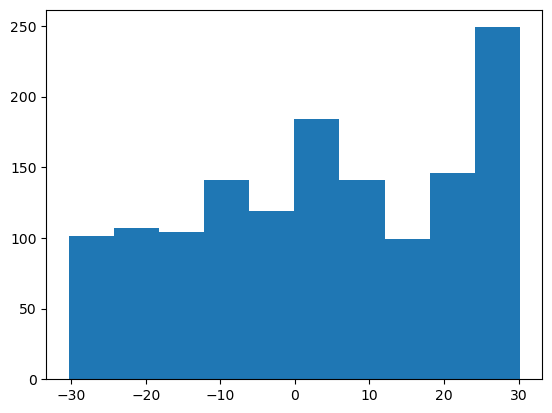

In [7]:
plt.hist(barycor)

Text(0, 0.5, 'HETVIPS RVs')

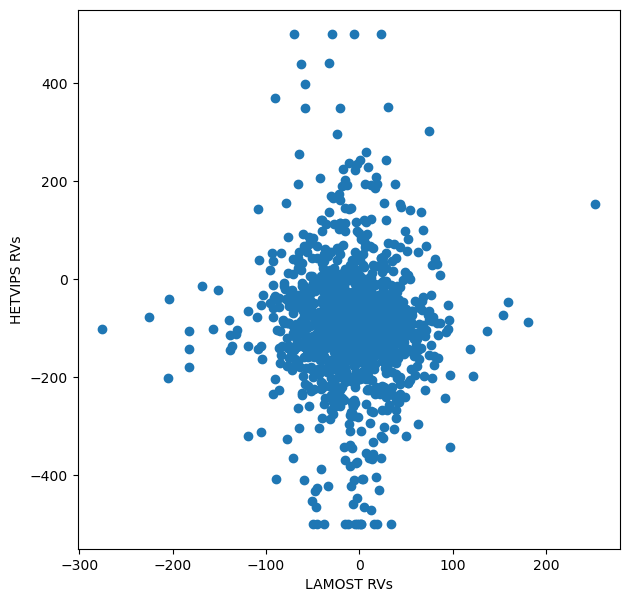

In [3]:
plt.figure(figsize=(7,7))
plt.scatter(rvs,het_rvs)
plt.xlabel("LAMOST RVs")
plt.ylabel("HETVIPS RVs")

Text(0, 0.5, 'HETVIPS RVs - LAMOST RVs')

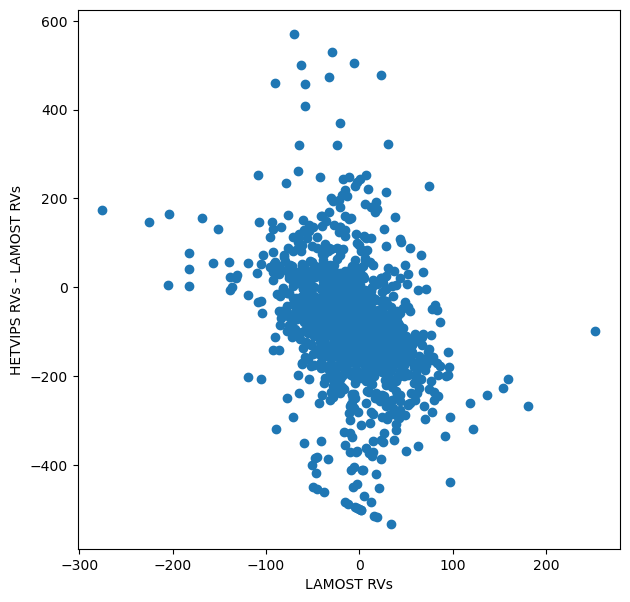

In [4]:
plt.figure(figsize=(7,7))
plt.scatter(rvs,het_rvs-rvs)
plt.xlabel("LAMOST RVs")
plt.ylabel("HETVIPS RVs - LAMOST RVs")

In [5]:
np.std(het_rvs-rvs)

127.45121397931149

In [3]:
def determine_radial_velocity_with_template(file_num):
    obs_spectrum = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/obs_file_{file_num}.txt.gz",nl=True)
    #logging.info("Radial velocity determination with template...")
    template = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/tmplt_file_{file_num}.txt.gz",nl=True)
    models, ccf = ispec.cross_correlate_with_template(obs_spectrum, template, \
                            lower_velocity_limit=-600, upper_velocity_limit=600, \
                            velocity_step=1.0, fourier=False)
    
    # Number of models represent the number of components
    components = len(models)
    # First component:

    if components == 0:
        rv = np.inf
        rv_err = np.inf
        return rv,rv_err
    
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s
    return rv, rv_err

predicted_rvs = []
predicted_errs = []
err_idx = []
for i in tqdm(range(1391)):
    pred_rv, pred_err = determine_radial_velocity_with_template(i)

    if pred_rv == np.inf:
        err_idx.append(i)
        
    predicted_rvs.append(pred_rv)
    predicted_errs.append(pred_err)

predicted_rvs = np.array(predicted_rvs)

100%|██████████| 1391/1391 [11:01<00:00,  2.10it/s]


In [ ]:
"""
def determine_radial_velocity_with_template_test(file_num):
    obs_spectrum = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/obs_file_{file_num}.txt.gz",nl=True)
    logging.info("Radial velocity determination with template...")
    template = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/tmplt_file_{file_num}.txt.gz",nl=True)
    models, ccf = ispec.cross_correlate_with_template(obs_spectrum, template, \
                            lower_velocity_limit=-600, upper_velocity_limit=600, \
                            velocity_step=1.0, fourier=False)
    
    # Number of models represent the number of components
    components = len(models)
    print(components)
    # First component:
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s
    return rv, rv_err


pred_rv, pred_err = determine_radial_velocity_with_template_test(177)
"""

In [4]:
pred_idx = [i for i in range(1391) if i not in err_idx]
np.savetxt("prevs.txt",np.array(predicted_rvs))
np.savetxt("non_err_idx.txt",pred_idx)


In [8]:
pred_idx = np.array(np.loadtxt("non_err_idx.txt"))
predicted_rvs = np.array(np.loadtxt("prevs.txt"))
pred_idx_int = [int(i) for i in pred_idx]

In [9]:
obs_wavs = np.linspace(3570,5440,936)
obs_flux = []
tmplt_flux = []

for i in tqdm(range(1391)):
    obs_spectrum = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/obs_file_{i}.txt.gz",nl=True)
    template = ispec.read_spectrum(f"/home/nachi/notebooks/notebooks/galactic_arc/formattedSpecs3/tmplt_file_{i}.txt.gz",nl=True)

    current_obs_flux = []
    current_tmplt_flux = []

    for j in range(len(obs_spectrum)):
        current_obs_flux.append(obs_spectrum[j][1])
        current_tmplt_flux.append(template[j][1])

    obs_flux.append(current_obs_flux)
    tmplt_flux.append(current_tmplt_flux)



100%|██████████| 1391/1391 [01:53<00:00, 12.21it/s]


In [10]:
snr_mask = np.where(snrs >= 30)
high_snr_predicted_rvs = predicted_rvs[snr_mask]
high_snr_lamost_rvs = rvs[snr_mask]
bad_delta_mask_tmp = np.where(np.abs(high_snr_predicted_rvs-high_snr_lamost_rvs) > 30)
good_delta_mask_tmp = np.where(np.abs(high_snr_predicted_rvs-high_snr_lamost_rvs) <= 30)
bad_delta_mask = snr_mask[0][bad_delta_mask_tmp]
good_delta_mask = snr_mask[0][good_delta_mask_tmp]

In [98]:
test_mask_1 = np.where(np.abs(predicted_rvs-rvs) > 30)
test_mask_2 = set(test_mask_1[0]).intersection(set(snr_mask[0]))

In [107]:
np.where(predicted_rvs == np.inf)

(array([ 177,  178,  395,  883,  887,  899,  933,  997, 1008, 1014, 1018,
        1025, 1027, 1084, 1141, 1149, 1153, 1196, 1227, 1282, 1299, 1300,
        1357, 1358, 1359, 1370, 1386]),)

LAMOST RV = -20.358905792236328, Predicted RV = -315.75, SNR = 658.714


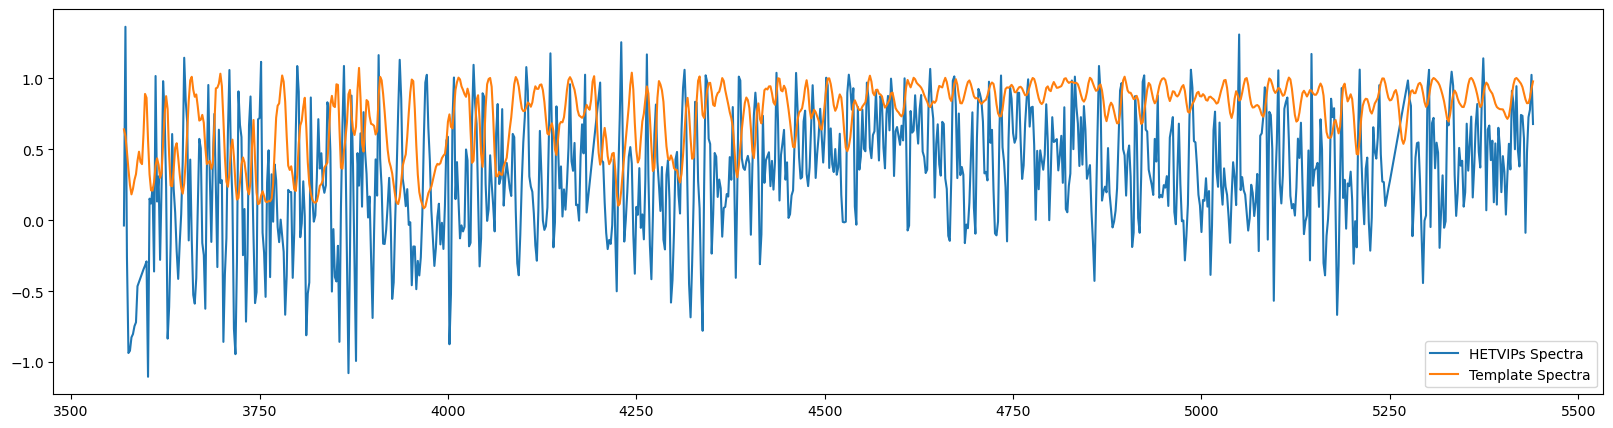

In [12]:
import random
plt.figure(figsize=(20,5))
#idx = bad_delta_mask[random.randint(0,len(bad_delta_mask))]
idx = bad_delta_mask[random.randint(0,len(bad_delta_mask))]

print(f"LAMOST RV = {rvs[idx]}, Predicted RV = {predicted_rvs[idx]}, SNR = {snrs[idx]}")
plt.plot(obs_wavs,obs_flux[idx],label = "HETVIPs Spectra")
plt.plot(obs_wavs,tmplt_flux[idx],label= "Template Spectra")
plt.legend()

In [9]:
unique, counts = np.unique(predicted_rvs, return_counts=True)
d = dict(zip(unique, counts))
d

{-597.37: 1,
 -579.94: 1,
 -579.66: 1,
 -574.87: 1,
 -573.72: 1,
 -553.02: 1,
 -502.65: 1,
 -501.68: 1,
 -478.85: 1,
 -476.08: 1,
 -450.06: 1,
 -440.45: 1,
 -438.72: 1,
 -436.61: 1,
 -435.59: 1,
 -420.93: 1,
 -420.18: 1,
 -410.57: 1,
 -400.1: 1,
 -397.2: 1,
 -395.27: 1,
 -392.52: 1,
 -387.63: 1,
 -387.55: 1,
 -387.49: 1,
 -378.46: 1,
 -377.38: 1,
 -376.09: 1,
 -367.49: 1,
 -359.52: 1,
 -347.91: 1,
 -345.44: 1,
 -339.24: 1,
 -338.58: 1,
 -337.61: 1,
 -333.43: 1,
 -330.07: 1,
 -315.75: 1,
 -314.62: 1,
 -313.17: 1,
 -307.41: 1,
 -306.85: 1,
 -304.84: 1,
 -303.92: 1,
 -295.1: 1,
 -294.92: 1,
 -293.56: 1,
 -291.77: 1,
 -285.77: 1,
 -281.48: 1,
 -271.07: 1,
 -271.04: 1,
 -268.75: 1,
 -266.86: 1,
 -264.39: 1,
 -263.25: 1,
 -261.46: 1,
 -259.91: 1,
 -251.0: 1,
 -249.23: 1,
 -248.95: 1,
 -247.7: 1,
 -246.04: 1,
 -244.45: 1,
 -242.65: 1,
 -241.73: 1,
 -238.28: 1,
 -237.96: 1,
 -236.07: 1,
 -235.46: 1,
 -235.4: 1,
 -234.94: 1,
 -230.86: 1,
 -230.75: 1,
 -230.12: 1,
 -223.78: 1,
 -223.65: 1,
 -222

/tmp/ipykernel_1035/14558029.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


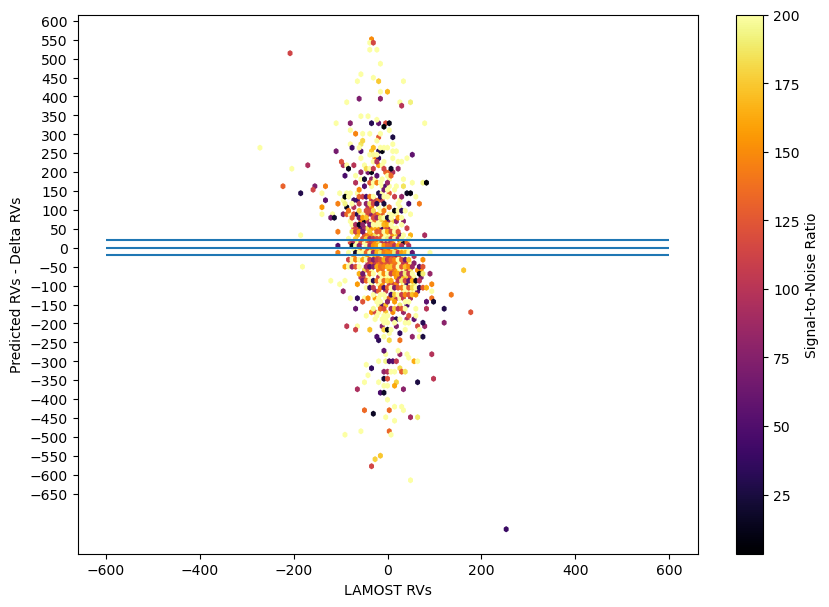

In [65]:
delta_RV =  predicted_rvs - rvs[pred_idx_int] + barycor[pred_idx_int]
cmap = plt.cm.get_cmap('inferno') 

snrs_test = [i if i <= 200 else 200 for i in snrs[pred_idx_int]]
fig, ax = plt.subplots(figsize=(10, 7))
hex = ax.hexbin(rvs[pred_idx_int],delta_RV, gridsize=(70,70),C = snrs_test, cmap=cmap)
plt.colorbar(hex, label='Signal-to-Noise Ratio')
plt.xlabel("LAMOST RVs")
plt.ylabel("Predicted RVs - Delta RVs")
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.hlines(20,-600,600)
plt.hlines(-20,-600,600)
#sc = plt.scatter(np.array(rvs[pred_idx]),delta_RV,c=snrs[pred_idx],cmap=cmap)
#plt.colorbar(sc, label='Signal-to-Noise Ratio') 
plt.show()

/tmp/ipykernel_1035/1841054277.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


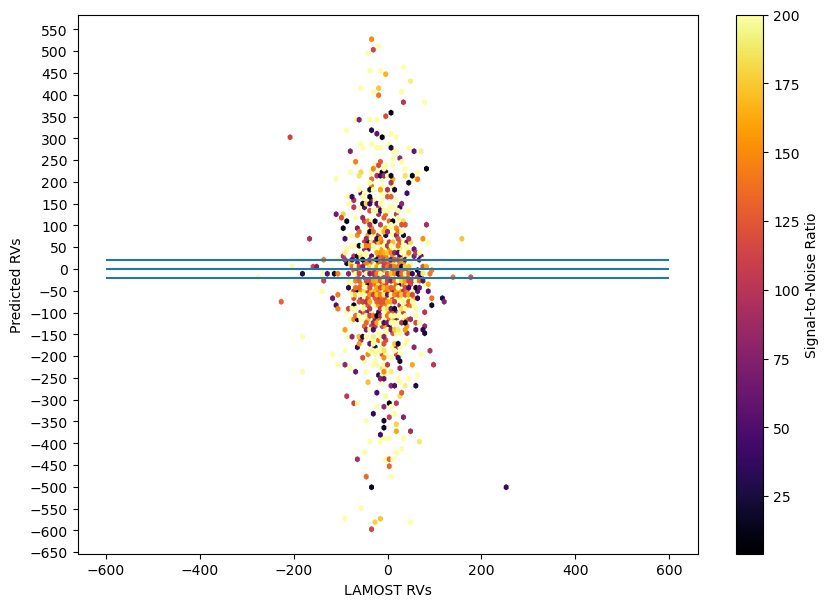

In [67]:
cmap = plt.cm.get_cmap('inferno') 

snrs_test = [i if i <= 200 else 200 for i in snrs[pred_idx_int]]
fig2, ax = plt.subplots(figsize=(10, 7))
hex = ax.hexbin(rvs[pred_idx_int],predicted_rvs, gridsize=(70,70),C = snrs_test, cmap=cmap)
plt.colorbar(hex, label='Signal-to-Noise Ratio')
plt.xlabel("LAMOST RVs")
plt.ylabel("Predicted RVs")
plt.yticks(np.arange(-650,650,50))
plt.hlines(0,-600,600)
plt.hlines(20,-600,600)
plt.hlines(-20,-600,600)
#sc = plt.scatter(np.array(rvs[pred_idx]),delta_RV,c=snrs[pred_idx],cmap=cmap)
#plt.colorbar(sc, label='Signal-to-Noise Ratio') 
plt.show()

In [61]:
pred_idx[np.where(delta_RV < -650)[0][0]]

877.0

In [9]:
np.mean(delta_RV),np.std(delta_RV)

(-9.497226958504841, 144.14945392550683)